# Hypervolume implementations benchmarking

We use an adaptation of the methodology presented in section 5 of [1].

## References

[1] M. Emmerich, & C. Fonseca (2011). Computing Hypervolume Contributions in Low Dimensions: Asymptotically Optimal Algorithm and Complexity Results. In Evolutionary Multi-Criterion Optimization (pp. 121–135). Springer Berlin Heidelberg.

In [1]:
import math
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt

import anguilla.hypervolume as hv

from anguilla.hypervolume.exact import hvkd
from anguilla.util import random_cliff_3d, random_linear_front, random_convex_front, random_concave_front

np.random.seed(4712)

In [2]:
def run_benchmark(implementations, names, nfronts=100, nruns=10, front_sizes = np.arange(10, 110, 10), front_type='cliff', dim=3):
    # computes times in nanoseconds
    frontsl = None
    if front_type == 'cliff':
        frontsl = [[random_cliff_3d(n) for _ in range(nfronts)] for n in front_sizes]
    elif front_type == 'convex':
        frontsl = [[random_convex_front(n, dim) for _ in range(nfronts)] for n in front_sizes]
    elif front_type == 'concave':
        frontsl = [[random_concave_front(n, dim) for _ in range(nfronts)] for n in front_sizes]
    elif front_type == 'linear':
        frontsl = [[random_linear_front(n, dim) for _ in range(nfronts)] for n in front_sizes]
    
    result = {}
    
    for implementation, name in zip(implementations, names):
        times = []
        for fronts in frontsl:
            elapsed = 0.0
            for front in fronts:
                ref = np.max(front, axis=0)
                t_start = time.perf_counter_ns()
                for _ in range(nruns):
                    vol = implementation(front, ref)
                t_end = time.perf_counter_ns()
                t_diff = t_end - t_start
                elapsed += t_diff / nruns
            elapsed /= nfronts
            times.append(elapsed)
        result[name] = times
    return result

In [3]:
def plot_results(resultsl, titles, front_sizes, figname):
    # assumes three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    i = 0
    for results, title in zip(resultsl, titles):
        ax = axs[i]
        i += 1
        ax.set_title(title)
        for name, times in results.items():
            times = np.array(times) / 1000.0
            ax.plot(front_sizes, times, label=name)
            ax.set_ylabel('Avg. running time (microsecs)')
            ax.set_xlabel('Front size')
            ax.legend()
        fig.tight_layout()
        fig.savefig(f'{figname}.png')

In [4]:
front_sizes = np.arange(10, 500, 25)

def anguilla_btree(*args, **kwargs):
    return hv.calculate(*args, use_btree=True, **kwargs)

def anguilla_rbtree(*args, **kwargs):
    return hv.calculate(*args, use_btree=False, **kwargs)

implementations = [hv.shark_calculate, anguilla_btree, anguilla_rbtree]
names = ['shark_bindings', 'cxx_btree', 'cxx_rbtree']
calculate_results_3d = []
for front_type, dim in [('cliff', 3), ('convex', 3), ('concave', 3)]:
    results = run_benchmark(implementations, names, front_sizes=front_sizes, front_type=front_type, dim=dim)
    calculate_results_3d.append(results)
    
implementations = [hv.shark_calculate, anguilla_rbtree]
names = ['shark_bindings', 'anguilla_cxx']
calculate_results_2d = []
for front_type, dim in [('linear', 2), ('convex', 2), ('concave', 2)]:
    results = run_benchmark(implementations, names, front_sizes=front_sizes, front_type=front_type, dim=dim)
    calculate_results_2d.append(results)

In [5]:
def anguilla_btree_c(*args, **kwargs):
    return hv.contributions(*args, use_btree=True, **kwargs)

def anguilla_rbtree_c(*args, **kwargs):
    return hv.contributions(*args, use_btree=False, **kwargs)

implementations = [hv.shark_contributions, anguilla_btree_c, anguilla_rbtree_c]
names = ['shark_bindings', 'anguilla_cxx_btree', 'anguilla_cxx_rbtree']
contribs_results_3d = []
for front_type, dim in [('cliff', 3), ('convex', 3), ('concave', 3)]:
    results = run_benchmark(implementations, names, front_sizes=front_sizes, front_type=front_type, dim=dim)
    contribs_results_3d.append(results)

implementations = [hv.shark_contributions, anguilla_rbtree]
names = ['shark_bindings', 'anguilla_cxx']
contribs_results_2d = []
for front_type, dim in [('linear', 2), ('convex', 2), ('concave', 2)]:
    results = run_benchmark(implementations, names, front_sizes=front_sizes, front_type=front_type, dim=dim)
    contribs_results_2d.append(results)

In [6]:
front_sizes_wfg = np.arange(10, 40, 5)
implementations = [hvkd]
names = ['py_wfg']
calculate_results_wfg_3d = []
for front_type, dim in [('cliff', 3), ('convex', 3), ('concave', 3)]:
    results = run_benchmark(implementations, names, front_sizes=front_sizes_wfg, front_type=front_type, dim=dim)
    calculate_results_wfg_3d.append(results)

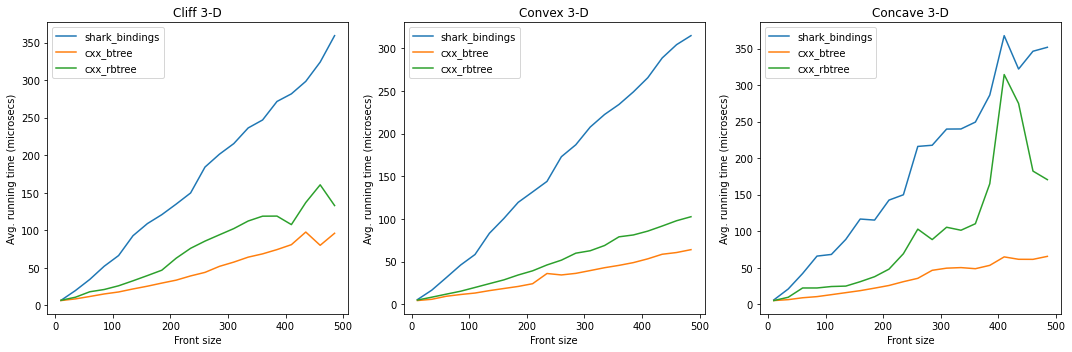

In [7]:
plot_results(calculate_results_3d, ['Cliff 3-D', 'Convex 3-D', 'Concave 3-D'], front_sizes, 'calculate_3d')

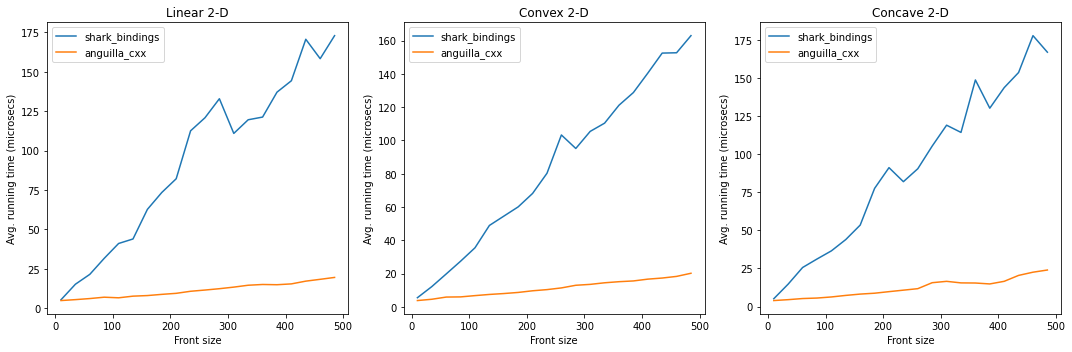

In [8]:
plot_results(calculate_results_2d, ['Linear 2-D', 'Convex 2-D', 'Concave 2-D'], front_sizes, 'calculate_2d')

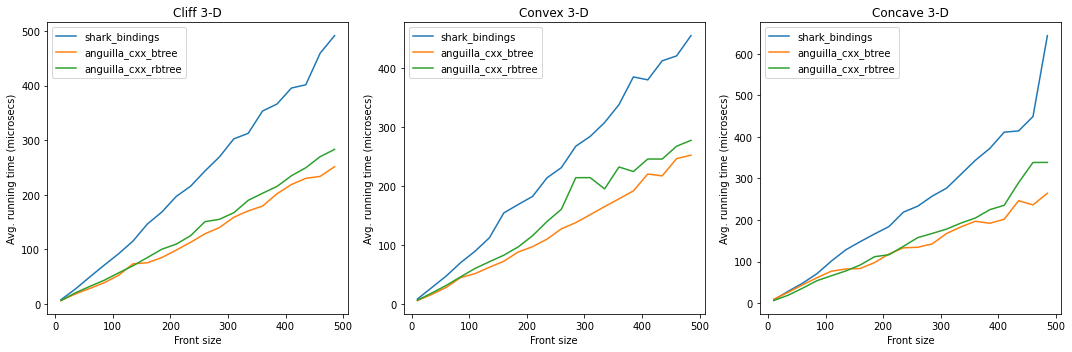

In [9]:
plot_results(contribs_results_3d, ['Cliff 3-D', 'Convex 3-D', 'Concave 3-D'], front_sizes, 'contribs_3d')

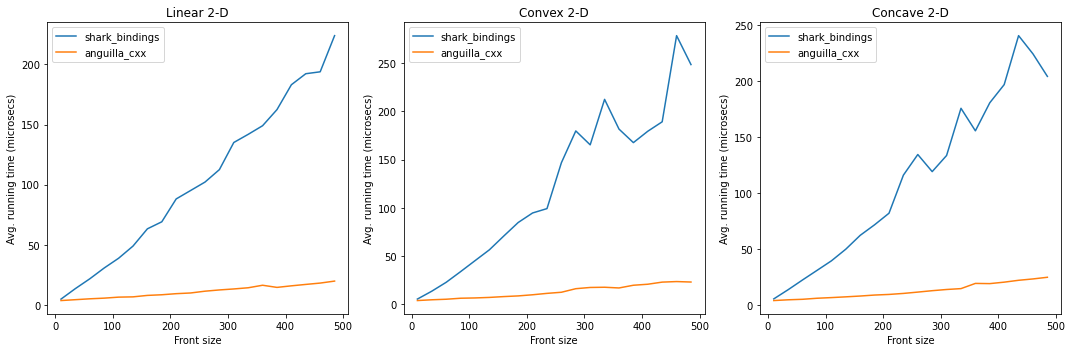

In [10]:
plot_results(contribs_results_2d, ['Linear 2-D', 'Convex 2-D', 'Concave 2-D'], front_sizes, 'contribs_2d')

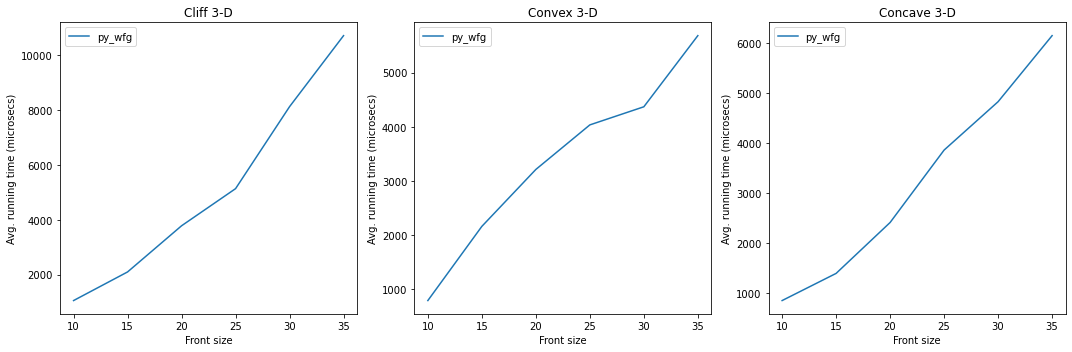

In [11]:
plot_results(calculate_results_wfg_3d, ['Cliff 3-D', 'Convex 3-D', 'Concave 3-D'], front_sizes_wfg, 'wfg_3d')